# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places
- different blur levels- complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop
- crop to the super8 resolution 720x480 or video 320x240
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input


## Optimization
- Use Adam
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete

## losses
- try l1 loss
- try perceptive loss vgg18

## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation



In [ ]:
# preprocess video from wmv to mp4

In [ ]:
#!ffmpeg -i '/home/filip/Videos/1987 first video making muffins.wmv'  -c:v libx264 -crf 23 -c:a aac -strict -2 -q:a 100 '/media/SSD/superres/1987 first video making muffins.mp4'

In [ ]:
#!python /media/SSD/superres/Zooming-Slow-Mo-CVPR-2020/codes/video_to_zsm.py --video /media/SSD/superres/snip.mp4  --model /media/SSD/superres/model/xiang2020zooming.pth --output /media/SSD/superres/muffins_test.mp4


In [ ]:
#preprocess from mpeg2 (DVD) to mp4 with antialiasing and only 120 seconds:
#ffmpeg -i 'Old 8mm Reels_1.VOB' -t 120  -vf "bwdif" -c:v libx264 -crf 28 -c:a aac -b:a 128k  'Old 8mm Reels_1.mp4'

In [ ]:
!pwd

To deinterlace
https://video.stackexchange.com/questions/17396/how-to-deinterlacing-with-ffmpeg
https://macilatthefront.blogspot.com/2017/04/deinterlacing-hd-footage-without-losing.html


In [1]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [2]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [3]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [4]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [5]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [6]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [7]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [8]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*self.kernel_width+2)
        h_wanted = int(self.crop_size[1]+2*self.kernel_width+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [9]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

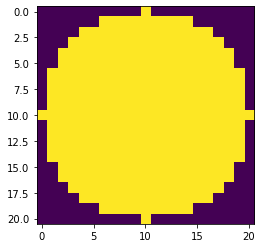

In [10]:
plt.imshow(Tophat2DKernel(10).array)

In [11]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [12]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [13]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [ ]:
#test the CropRescale transform
im=load_frame(instances[5])
#im = Grayscale(num_output_channels=1)(im)
im_res = RescaleCrop(crop_size = (480,720), kernel_width=10)(im)
im_res = Crappify(crop_size = (480,720), factor_range=(2,8))(im_res)
print(im.size,im_res.size)
type(im_res)
im_res

In [ ]:
#

In [ ]:
instances[19]

In [ ]:
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
#im_gt = Image.open("/home/filip/Pictures/Screenshot from CADDX000009.MP4.png").convert("RGB")
im_res = CropRescale(crop_size = 256, factor_range=(4,4))(im_gt)
print(im_gt.size,im_res.size)
type(im_res)
im_res

In [14]:


def input_transform(crop_size, factor_range):
    
    
    return Compose([
        
        Crappify(crop_size,factor_range), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, upscale_factor, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, upscale_factor),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, upscale_factor):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, upscale_factor,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [15]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
upscale_factor=(2,6)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [16]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [17]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            upscale_factor=upscale_factor,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [18]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [19]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

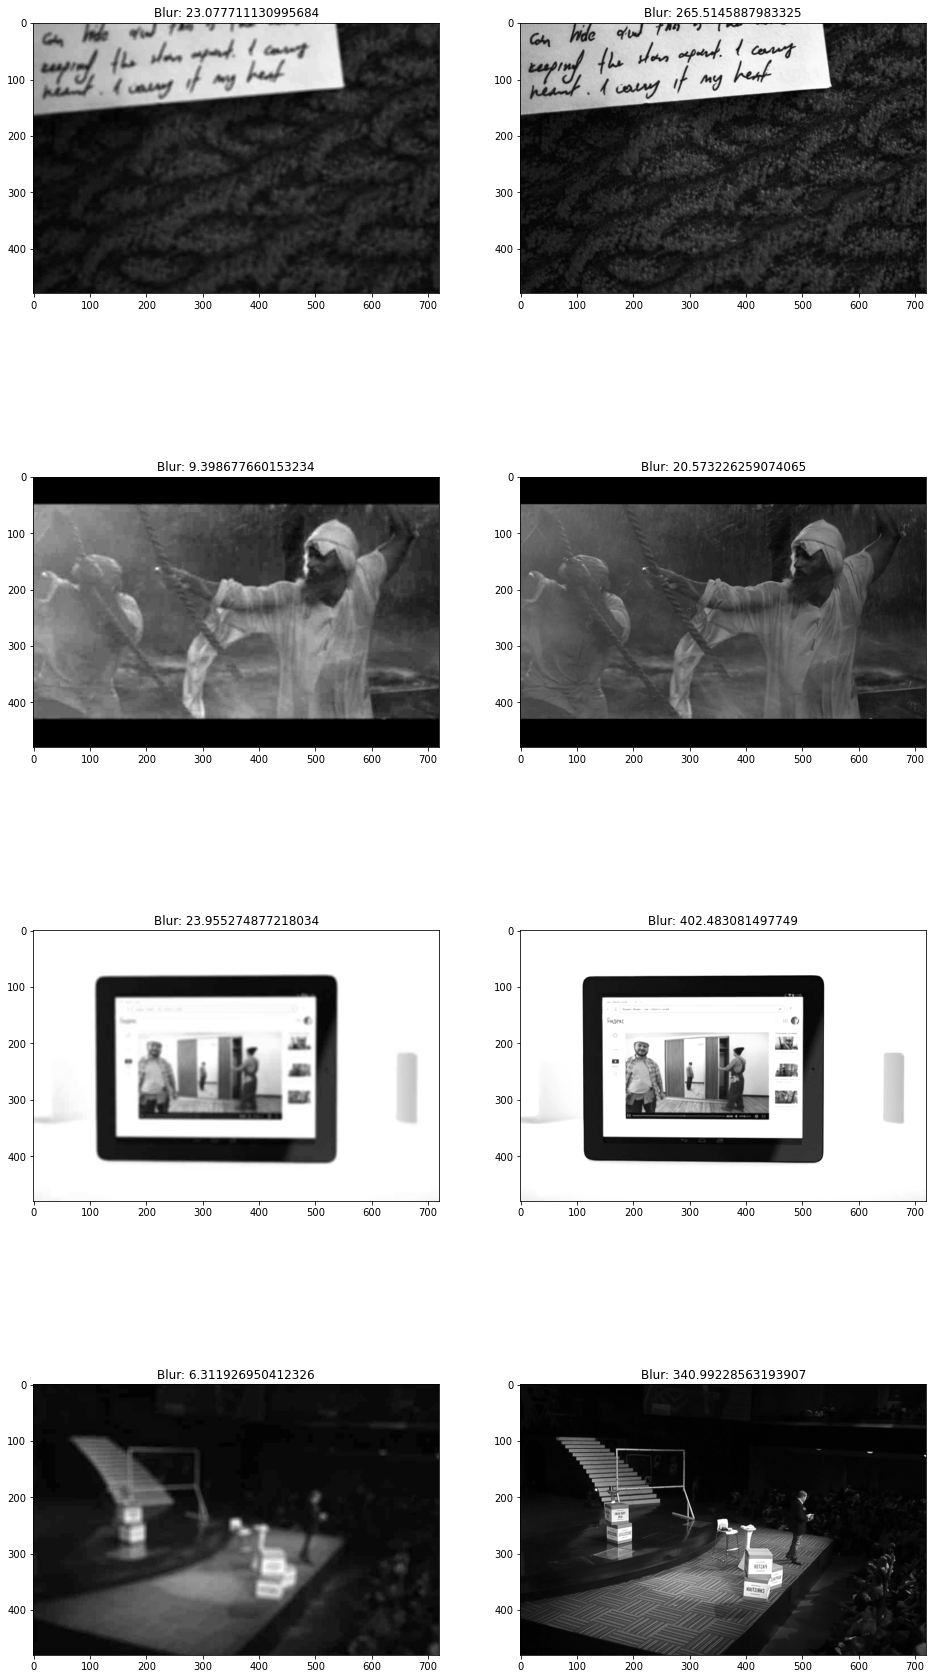

In [20]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [21]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [ ]:
#need to try this
# from https://github.com/xiezw5/Component-Divide-and-Conquer-for-Real-World-Image-Super-Resolution/blob/master/CDC/modules/loss.py

class GradientPenaltyLoss(nn.Module):
    def __init__(self, device=torch.device('cpu')):
        super(GradientPenaltyLoss, self).__init__()
        self.register_buffer('grad_outputs', torch.Tensor())
        self.grad_outputs = self.grad_outputs.to(device)

    def get_grad_outputs(self, input):
        if self.grad_outputs.size() != input.size():
            self.grad_outputs.resize_(input.size()).fill_(1.0)
        return self.grad_outputs

    def forward(self, interp, interp_crit):
        grad_outputs = self.get_grad_outputs(interp_crit)
        grad_interp = torch.autograd.grad(outputs=interp_crit, inputs=interp, \
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
        grad_interp = grad_interp.view(grad_interp.size(0), -1)
        grad_interp_norm = grad_interp.norm(2, dim=1)

        loss = ((grad_interp_norm - 1)**2).mean()
        return loss

In [22]:
#criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [23]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        return totloss

In [24]:
criterion = P_Loss()
#criterion.cuda()

In [25]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 20

In [26]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [27]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [28]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [29]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "percepmodel2_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
def train(training_data_loader, optimizer, model, criterion, epoch):
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()

        loss = criterion(model(input), target)
        optimizer.zero_grad()
        loss.backward() 
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        optimizer.step()

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), loss.data))

In [30]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [31]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    
    cum_loss = 0
    ct=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
            

In [32]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()

for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Epoch = 1, lr = 0.001
===> Time: 2020-09-18 17:28:26.702011 Epoch[1](10/1586): LR: 0.001 : Loss: 0.0773925781
===> Time: 2020-09-18 17:28:37.361770 Epoch[1](20/1586): LR: 0.001 : Loss: 0.0565795898
===> Time: 2020-09-18 17:28:48.333347 Epoch[1](30/1586): LR: 0.001 : Loss: 0.0559082031
===> Time: 2020-09-18 17:28:59.401581 Epoch[1](40/1586): LR: 0.001 : Loss: 0.0506286621
===> Time: 2020-09-18 17:29:10.353191 Epoch[1](50/1586): LR: 0.001 : Loss: 0.0551757812
===> Time: 2020-09-18 17:29:21.139152 Epoch[1](60/1586): LR: 0.001 : Loss: 0.0532531738
===> Time: 2020-09-18 17:29:32.236112 Epoch[1](70/1586): LR: 0.001 : Loss: 0.0532226562
===> Time: 2020-09-18 17:29:43.167564 Epoch[1](80/1586): LR: 0.001 : Loss: 0.0513610840
===> Time: 2020-09-18 17:29:54.095989 Epoch[1](90/1586): LR: 0.001 : Loss: 0.0494689941
===> Time: 2020-09-18 17:30:05.161899 Epoch[1](100/1586): LR: 0.001 : Loss: 0.0451660156
===> Time: 2020-09-18 17:30:15.960922 Epoch[1](110/1586): LR: 0.001 : Loss: 0.0485839844
===> Tim

===> Time: 2020-09-18 17:44:59.459668 Epoch[1](930/1586): LR: 0.001 : Loss: 0.0442199707
===> Time: 2020-09-18 17:45:10.001561 Epoch[1](940/1586): LR: 0.001 : Loss: 0.0389099121
===> Time: 2020-09-18 17:45:20.663383 Epoch[1](950/1586): LR: 0.001 : Loss: 0.0391845703
===> Time: 2020-09-18 17:45:31.337930 Epoch[1](960/1586): LR: 0.001 : Loss: 0.0432128906
===> Time: 2020-09-18 17:45:41.931381 Epoch[1](970/1586): LR: 0.001 : Loss: 0.0394287109
===> Time: 2020-09-18 17:45:52.761384 Epoch[1](980/1586): LR: 0.001 : Loss: 0.0417785645
===> Time: 2020-09-18 17:46:03.115662 Epoch[1](990/1586): LR: 0.001 : Loss: 0.0313415527
===> Time: 2020-09-18 17:46:13.678451 Epoch[1](1000/1586): LR: 0.001 : Loss: 0.0477600098
===> Time: 2020-09-18 17:46:24.151307 Epoch[1](1010/1586): LR: 0.001 : Loss: 0.0444030762
===> Time: 2020-09-18 17:46:34.692488 Epoch[1](1020/1586): LR: 0.001 : Loss: 0.0443115234
===> Time: 2020-09-18 17:46:45.093688 Epoch[1](1030/1586): LR: 0.001 : Loss: 0.0429687500
===> Time: 2020-0

===> Time: 2020-09-18 18:01:11.177062 Epoch[2](260/1586): LR: 0.001 : Loss: 0.0407714844
===> Time: 2020-09-18 18:01:21.966283 Epoch[2](270/1586): LR: 0.001 : Loss: 0.0472717285
===> Time: 2020-09-18 18:01:32.530314 Epoch[2](280/1586): LR: 0.001 : Loss: 0.0494995117
===> Time: 2020-09-18 18:01:43.122668 Epoch[2](290/1586): LR: 0.001 : Loss: 0.0389404297
===> Time: 2020-09-18 18:01:53.568384 Epoch[2](300/1586): LR: 0.001 : Loss: 0.0401916504
===> Time: 2020-09-18 18:02:04.033683 Epoch[2](310/1586): LR: 0.001 : Loss: 0.0401611328
===> Time: 2020-09-18 18:02:14.670749 Epoch[2](320/1586): LR: 0.001 : Loss: 0.0426940918
===> Time: 2020-09-18 18:02:25.427527 Epoch[2](330/1586): LR: 0.001 : Loss: 0.0403442383
===> Time: 2020-09-18 18:02:36.036894 Epoch[2](340/1586): LR: 0.001 : Loss: 0.0377502441
===> Time: 2020-09-18 18:02:46.689947 Epoch[2](350/1586): LR: 0.001 : Loss: 0.0425109863
===> Time: 2020-09-18 18:02:57.369523 Epoch[2](360/1586): LR: 0.001 : Loss: 0.0401916504
===> Time: 2020-09-18

===> Time: 2020-09-18 18:17:21.031112 Epoch[2](1180/1586): LR: 0.001 : Loss: 0.0379028320
===> Time: 2020-09-18 18:17:31.555444 Epoch[2](1190/1586): LR: 0.001 : Loss: 0.0390625000
===> Time: 2020-09-18 18:17:42.756591 Epoch[2](1200/1586): LR: 0.001 : Loss: 0.0408935547
===> Time: 2020-09-18 18:17:53.412994 Epoch[2](1210/1586): LR: 0.001 : Loss: 0.0379943848
===> Time: 2020-09-18 18:18:03.743585 Epoch[2](1220/1586): LR: 0.001 : Loss: 0.0411376953
===> Time: 2020-09-18 18:18:14.329788 Epoch[2](1230/1586): LR: 0.001 : Loss: 0.0479125977
===> Time: 2020-09-18 18:18:24.718180 Epoch[2](1240/1586): LR: 0.001 : Loss: 0.0372314453
===> Time: 2020-09-18 18:18:34.930532 Epoch[2](1250/1586): LR: 0.001 : Loss: 0.0359802246
===> Time: 2020-09-18 18:18:45.428540 Epoch[2](1260/1586): LR: 0.001 : Loss: 0.0401000977
===> Time: 2020-09-18 18:18:56.045248 Epoch[2](1270/1586): LR: 0.001 : Loss: 0.0398559570
===> Time: 2020-09-18 18:19:06.255428 Epoch[2](1280/1586): LR: 0.001 : Loss: 0.0415039062
===> Time:

===> Time: 2020-09-18 18:33:19.375416 Epoch[3](510/1586): LR: 0.001 : Loss: 0.0388183594
===> Time: 2020-09-18 18:33:29.988796 Epoch[3](520/1586): LR: 0.001 : Loss: 0.0398559570
===> Time: 2020-09-18 18:33:40.287443 Epoch[3](530/1586): LR: 0.001 : Loss: 0.0385742188
===> Time: 2020-09-18 18:33:50.830500 Epoch[3](540/1586): LR: 0.001 : Loss: 0.0407104492
===> Time: 2020-09-18 18:34:01.222804 Epoch[3](550/1586): LR: 0.001 : Loss: 0.0471191406
===> Time: 2020-09-18 18:34:11.695440 Epoch[3](560/1586): LR: 0.001 : Loss: 0.0445556641
===> Time: 2020-09-18 18:34:22.234718 Epoch[3](570/1586): LR: 0.001 : Loss: 0.0450439453
===> Time: 2020-09-18 18:34:32.819101 Epoch[3](580/1586): LR: 0.001 : Loss: 0.0439453125
===> Time: 2020-09-18 18:34:43.204491 Epoch[3](590/1586): LR: 0.001 : Loss: 0.0421752930
===> Time: 2020-09-18 18:34:53.780181 Epoch[3](600/1586): LR: 0.001 : Loss: 0.0406494141
===> Time: 2020-09-18 18:35:04.151482 Epoch[3](610/1586): LR: 0.001 : Loss: 0.0390625000
===> Time: 2020-09-18

===> Time: 2020-09-18 18:49:20.582394 Epoch[3](1430/1586): LR: 0.001 : Loss: 0.0397338867
===> Time: 2020-09-18 18:49:31.237713 Epoch[3](1440/1586): LR: 0.001 : Loss: 0.0419311523
===> Time: 2020-09-18 18:49:41.559391 Epoch[3](1450/1586): LR: 0.001 : Loss: 0.0433349609
===> Time: 2020-09-18 18:49:52.150959 Epoch[3](1460/1586): LR: 0.001 : Loss: 0.0414428711
===> Time: 2020-09-18 18:50:02.572728 Epoch[3](1470/1586): LR: 0.001 : Loss: 0.0368957520
===> Time: 2020-09-18 18:50:13.068557 Epoch[3](1480/1586): LR: 0.001 : Loss: 0.0378417969
===> Time: 2020-09-18 18:50:23.507651 Epoch[3](1490/1586): LR: 0.001 : Loss: 0.0418701172
===> Time: 2020-09-18 18:50:33.712624 Epoch[3](1500/1586): LR: 0.001 : Loss: 0.0350341797
===> Time: 2020-09-18 18:50:44.209851 Epoch[3](1510/1586): LR: 0.001 : Loss: 0.0429077148
===> Time: 2020-09-18 18:50:54.606385 Epoch[3](1520/1586): LR: 0.001 : Loss: 0.0454711914
===> Time: 2020-09-18 18:51:05.038506 Epoch[3](1530/1586): LR: 0.001 : Loss: 0.0435791016
===> Time:

===> Time: 2020-09-18 19:03:12.166493 Epoch[4](640/1586): LR: 0.00031622776601683794 : Loss: 0.0358886719
===> Time: 2020-09-18 19:03:22.525399 Epoch[4](650/1586): LR: 0.00031622776601683794 : Loss: 0.0438232422
===> Time: 2020-09-18 19:03:33.074454 Epoch[4](660/1586): LR: 0.00031622776601683794 : Loss: 0.0421752930
===> Time: 2020-09-18 19:03:43.367444 Epoch[4](670/1586): LR: 0.00031622776601683794 : Loss: 0.0314941406
===> Time: 2020-09-18 19:03:53.652451 Epoch[4](680/1586): LR: 0.00031622776601683794 : Loss: 0.0319519043
===> Time: 2020-09-18 19:04:04.168234 Epoch[4](690/1586): LR: 0.00031622776601683794 : Loss: 0.0351867676
===> Time: 2020-09-18 19:04:14.751920 Epoch[4](700/1586): LR: 0.00031622776601683794 : Loss: 0.0396728516
===> Time: 2020-09-18 19:04:25.113621 Epoch[4](710/1586): LR: 0.00031622776601683794 : Loss: 0.0420532227
===> Time: 2020-09-18 19:04:35.748281 Epoch[4](720/1586): LR: 0.00031622776601683794 : Loss: 0.0409851074
===> Time: 2020-09-18 19:04:46.353510 Epoch[4]

===> Time: 2020-09-18 19:16:38.285346 Epoch[4](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0401000977
===> Time: 2020-09-18 19:16:48.694923 Epoch[4](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0376281738
===> Time: 2020-09-18 19:16:59.153353 Epoch[4](1430/1586): LR: 0.00031622776601683794 : Loss: 0.0423583984
===> Time: 2020-09-18 19:17:09.879316 Epoch[4](1440/1586): LR: 0.00031622776601683794 : Loss: 0.0403137207
===> Time: 2020-09-18 19:17:20.675851 Epoch[4](1450/1586): LR: 0.00031622776601683794 : Loss: 0.0380859375
===> Time: 2020-09-18 19:17:31.043215 Epoch[4](1460/1586): LR: 0.00031622776601683794 : Loss: 0.0382995605
===> Time: 2020-09-18 19:17:41.531426 Epoch[4](1470/1586): LR: 0.00031622776601683794 : Loss: 0.0389099121
===> Time: 2020-09-18 19:17:52.080244 Epoch[4](1480/1586): LR: 0.00031622776601683794 : Loss: 0.0415344238
===> Time: 2020-09-18 19:18:02.571539 Epoch[4](1490/1586): LR: 0.00031622776601683794 : Loss: 0.0381164551
===> Time: 2020-09-18 19:18:12.941276

===> Time: 2020-09-18 19:30:11.358206 Epoch[5](600/1586): LR: 0.00031622776601683794 : Loss: 0.0346984863
===> Time: 2020-09-18 19:30:21.802971 Epoch[5](610/1586): LR: 0.00031622776601683794 : Loss: 0.0337219238
===> Time: 2020-09-18 19:30:32.327673 Epoch[5](620/1586): LR: 0.00031622776601683794 : Loss: 0.0377807617
===> Time: 2020-09-18 19:30:42.852741 Epoch[5](630/1586): LR: 0.00031622776601683794 : Loss: 0.0382385254
===> Time: 2020-09-18 19:30:53.313739 Epoch[5](640/1586): LR: 0.00031622776601683794 : Loss: 0.0453491211
===> Time: 2020-09-18 19:31:03.849181 Epoch[5](650/1586): LR: 0.00031622776601683794 : Loss: 0.0335083008
===> Time: 2020-09-18 19:31:14.253142 Epoch[5](660/1586): LR: 0.00031622776601683794 : Loss: 0.0356140137
===> Time: 2020-09-18 19:31:24.696270 Epoch[5](670/1586): LR: 0.00031622776601683794 : Loss: 0.0367126465
===> Time: 2020-09-18 19:31:35.171323 Epoch[5](680/1586): LR: 0.00031622776601683794 : Loss: 0.0394897461
===> Time: 2020-09-18 19:31:45.572472 Epoch[5]

===> Time: 2020-09-18 19:43:34.949065 Epoch[5](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0422973633
===> Time: 2020-09-18 19:43:45.403278 Epoch[5](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0368652344
===> Time: 2020-09-18 19:43:55.851780 Epoch[5](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0387573242
===> Time: 2020-09-18 19:44:06.282195 Epoch[5](1400/1586): LR: 0.00031622776601683794 : Loss: 0.0318908691
===> Time: 2020-09-18 19:44:16.757149 Epoch[5](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0384826660
===> Time: 2020-09-18 19:44:26.896750 Epoch[5](1420/1586): LR: 0.00031622776601683794 : Loss: 0.0382690430
===> Time: 2020-09-18 19:44:37.332084 Epoch[5](1430/1586): LR: 0.00031622776601683794 : Loss: 0.0352172852
===> Time: 2020-09-18 19:44:47.757528 Epoch[5](1440/1586): LR: 0.00031622776601683794 : Loss: 0.0383300781
===> Time: 2020-09-18 19:44:58.170977 Epoch[5](1450/1586): LR: 0.00031622776601683794 : Loss: 0.0385131836
===> Time: 2020-09-18 19:45:08.568971

===> Time: 2020-09-18 19:57:05.843248 Epoch[6](560/1586): LR: 0.00031622776601683794 : Loss: 0.0403137207
===> Time: 2020-09-18 19:57:16.186751 Epoch[6](570/1586): LR: 0.00031622776601683794 : Loss: 0.0338745117
===> Time: 2020-09-18 19:57:26.824309 Epoch[6](580/1586): LR: 0.00031622776601683794 : Loss: 0.0400390625
===> Time: 2020-09-18 19:57:37.118859 Epoch[6](590/1586): LR: 0.00031622776601683794 : Loss: 0.0358276367
===> Time: 2020-09-18 19:57:47.406679 Epoch[6](600/1586): LR: 0.00031622776601683794 : Loss: 0.0329895020
===> Time: 2020-09-18 19:57:57.700434 Epoch[6](610/1586): LR: 0.00031622776601683794 : Loss: 0.0361633301
===> Time: 2020-09-18 19:58:08.262540 Epoch[6](620/1586): LR: 0.00031622776601683794 : Loss: 0.0376281738
===> Time: 2020-09-18 19:58:18.905329 Epoch[6](630/1586): LR: 0.00031622776601683794 : Loss: 0.0343017578
===> Time: 2020-09-18 19:58:29.286404 Epoch[6](640/1586): LR: 0.00031622776601683794 : Loss: 0.0386352539
===> Time: 2020-09-18 19:58:39.644288 Epoch[6]

===> Time: 2020-09-18 20:10:30.700588 Epoch[6](1330/1586): LR: 0.00031622776601683794 : Loss: 0.0402832031
===> Time: 2020-09-18 20:10:41.088357 Epoch[6](1340/1586): LR: 0.00031622776601683794 : Loss: 0.0343933105
===> Time: 2020-09-18 20:10:51.454037 Epoch[6](1350/1586): LR: 0.00031622776601683794 : Loss: 0.0372924805
===> Time: 2020-09-18 20:11:02.099353 Epoch[6](1360/1586): LR: 0.00031622776601683794 : Loss: 0.0426025391
===> Time: 2020-09-18 20:11:12.678170 Epoch[6](1370/1586): LR: 0.00031622776601683794 : Loss: 0.0397949219
===> Time: 2020-09-18 20:11:23.025633 Epoch[6](1380/1586): LR: 0.00031622776601683794 : Loss: 0.0374755859
===> Time: 2020-09-18 20:11:33.618042 Epoch[6](1390/1586): LR: 0.00031622776601683794 : Loss: 0.0419006348
===> Time: 2020-09-18 20:11:44.061209 Epoch[6](1400/1586): LR: 0.00031622776601683794 : Loss: 0.0379028320
===> Time: 2020-09-18 20:11:54.378202 Epoch[6](1410/1586): LR: 0.00031622776601683794 : Loss: 0.0383911133
===> Time: 2020-09-18 20:12:04.713427

===> Time: 2020-09-18 20:25:34.990047 Epoch[7](610/1586): LR: 0.0001 : Loss: 0.0353088379
===> Time: 2020-09-18 20:25:45.547407 Epoch[7](620/1586): LR: 0.0001 : Loss: 0.0398254395
===> Time: 2020-09-18 20:25:55.825116 Epoch[7](630/1586): LR: 0.0001 : Loss: 0.0349426270
===> Time: 2020-09-18 20:26:06.346695 Epoch[7](640/1586): LR: 0.0001 : Loss: 0.0385742188
===> Time: 2020-09-18 20:26:16.889901 Epoch[7](650/1586): LR: 0.0001 : Loss: 0.0346679688
===> Time: 2020-09-18 20:26:27.327485 Epoch[7](660/1586): LR: 0.0001 : Loss: 0.0325012207
===> Time: 2020-09-18 20:26:37.793984 Epoch[7](670/1586): LR: 0.0001 : Loss: 0.0401611328
===> Time: 2020-09-18 20:26:48.154770 Epoch[7](680/1586): LR: 0.0001 : Loss: 0.0338439941
===> Time: 2020-09-18 20:26:58.594708 Epoch[7](690/1586): LR: 0.0001 : Loss: 0.0394592285
===> Time: 2020-09-18 20:27:09.121941 Epoch[7](700/1586): LR: 0.0001 : Loss: 0.0383300781
===> Time: 2020-09-18 20:27:19.721706 Epoch[7](710/1586): LR: 0.0001 : Loss: 0.0400085449
===> Time:

===> Time: 2020-09-18 20:41:26.391416 Epoch[7](1520/1586): LR: 0.0001 : Loss: 0.0359191895
===> Time: 2020-09-18 20:41:36.771666 Epoch[7](1530/1586): LR: 0.0001 : Loss: 0.0352783203
===> Time: 2020-09-18 20:41:47.291135 Epoch[7](1540/1586): LR: 0.0001 : Loss: 0.0411376953
===> Time: 2020-09-18 20:41:57.706379 Epoch[7](1550/1586): LR: 0.0001 : Loss: 0.0366516113
===> Time: 2020-09-18 20:42:08.003991 Epoch[7](1560/1586): LR: 0.0001 : Loss: 0.0351562500
===> Time: 2020-09-18 20:42:18.473436 Epoch[7](1570/1586): LR: 0.0001 : Loss: 0.0379333496
===> Time: 2020-09-18 20:42:28.921092 Epoch[7](1580/1586): LR: 0.0001 : Loss: 0.0377807617
Checkpoint saved to checkpoint/percepmodel2_epoch_7.pth
Epoch = 8, lr = 0.0001
===> Time: 2020-09-18 20:42:45.398438 Epoch[8](10/1586): LR: 0.0001 : Loss: 0.0419921875
===> Time: 2020-09-18 20:42:55.832272 Epoch[8](20/1586): LR: 0.0001 : Loss: 0.0388488770
===> Time: 2020-09-18 20:43:06.175201 Epoch[8](30/1586): LR: 0.0001 : Loss: 0.0370483398
===> Time: 2020-0

===> Time: 2020-09-18 20:57:23.104668 Epoch[8](850/1586): LR: 0.0001 : Loss: 0.0324096680
===> Time: 2020-09-18 20:57:33.581141 Epoch[8](860/1586): LR: 0.0001 : Loss: 0.0438232422
===> Time: 2020-09-18 20:57:44.076369 Epoch[8](870/1586): LR: 0.0001 : Loss: 0.0400390625
===> Time: 2020-09-18 20:57:54.627410 Epoch[8](880/1586): LR: 0.0001 : Loss: 0.0407104492
===> Time: 2020-09-18 20:58:05.049663 Epoch[8](890/1586): LR: 0.0001 : Loss: 0.0366516113
===> Time: 2020-09-18 20:58:15.292210 Epoch[8](900/1586): LR: 0.0001 : Loss: 0.0357666016
===> Time: 2020-09-18 20:58:25.664378 Epoch[8](910/1586): LR: 0.0001 : Loss: 0.0363769531
===> Time: 2020-09-18 20:58:36.181040 Epoch[8](920/1586): LR: 0.0001 : Loss: 0.0364074707
===> Time: 2020-09-18 20:58:46.655104 Epoch[8](930/1586): LR: 0.0001 : Loss: 0.0337829590
===> Time: 2020-09-18 20:58:57.142515 Epoch[8](940/1586): LR: 0.0001 : Loss: 0.0357971191
===> Time: 2020-09-18 20:59:07.384276 Epoch[8](950/1586): LR: 0.0001 : Loss: 0.0349121094
===> Time:

===> Time: 2020-09-18 21:13:10.085771 Epoch[9](170/1586): LR: 0.0001 : Loss: 0.0336914062
===> Time: 2020-09-18 21:13:20.751101 Epoch[9](180/1586): LR: 0.0001 : Loss: 0.0434570312
===> Time: 2020-09-18 21:13:31.058136 Epoch[9](190/1586): LR: 0.0001 : Loss: 0.0326843262
===> Time: 2020-09-18 21:13:41.611902 Epoch[9](200/1586): LR: 0.0001 : Loss: 0.0330200195
===> Time: 2020-09-18 21:13:52.213131 Epoch[9](210/1586): LR: 0.0001 : Loss: 0.0368041992
===> Time: 2020-09-18 21:14:02.678167 Epoch[9](220/1586): LR: 0.0001 : Loss: 0.0362854004
===> Time: 2020-09-18 21:14:13.171301 Epoch[9](230/1586): LR: 0.0001 : Loss: 0.0327453613
===> Time: 2020-09-18 21:14:23.406127 Epoch[9](240/1586): LR: 0.0001 : Loss: 0.0342407227
===> Time: 2020-09-18 21:14:33.654519 Epoch[9](250/1586): LR: 0.0001 : Loss: 0.0389404297
===> Time: 2020-09-18 21:14:43.880024 Epoch[9](260/1586): LR: 0.0001 : Loss: 0.0340270996
===> Time: 2020-09-18 21:14:54.358657 Epoch[9](270/1586): LR: 0.0001 : Loss: 0.0354003906
===> Time:

===> Time: 2020-09-18 21:29:01.493594 Epoch[9](1080/1586): LR: 0.0001 : Loss: 0.0377502441
===> Time: 2020-09-18 21:29:11.919523 Epoch[9](1090/1586): LR: 0.0001 : Loss: 0.0336608887
===> Time: 2020-09-18 21:29:22.215657 Epoch[9](1100/1586): LR: 0.0001 : Loss: 0.0369567871
===> Time: 2020-09-18 21:29:32.711099 Epoch[9](1110/1586): LR: 0.0001 : Loss: 0.0422363281
===> Time: 2020-09-18 21:29:43.334339 Epoch[9](1120/1586): LR: 0.0001 : Loss: 0.0339660645
===> Time: 2020-09-18 21:29:53.889051 Epoch[9](1130/1586): LR: 0.0001 : Loss: 0.0383605957
===> Time: 2020-09-18 21:30:04.181585 Epoch[9](1140/1586): LR: 0.0001 : Loss: 0.0340576172
===> Time: 2020-09-18 21:30:14.702483 Epoch[9](1150/1586): LR: 0.0001 : Loss: 0.0316467285
===> Time: 2020-09-18 21:30:25.213294 Epoch[9](1160/1586): LR: 0.0001 : Loss: 0.0371704102
===> Time: 2020-09-18 21:30:35.658351 Epoch[9](1170/1586): LR: 0.0001 : Loss: 0.0428161621
===> Time: 2020-09-18 21:30:46.151940 Epoch[9](1180/1586): LR: 0.0001 : Loss: 0.0433044434

===> Time: 2020-09-18 21:43:57.297585 Epoch[10](350/1586): LR: 3.16227766016838e-05 : Loss: 0.0394287109
===> Time: 2020-09-18 21:44:07.773103 Epoch[10](360/1586): LR: 3.16227766016838e-05 : Loss: 0.0324096680
===> Time: 2020-09-18 21:44:18.078295 Epoch[10](370/1586): LR: 3.16227766016838e-05 : Loss: 0.0371398926
===> Time: 2020-09-18 21:44:28.745834 Epoch[10](380/1586): LR: 3.16227766016838e-05 : Loss: 0.0433654785
===> Time: 2020-09-18 21:44:39.500552 Epoch[10](390/1586): LR: 3.16227766016838e-05 : Loss: 0.0368957520
===> Time: 2020-09-18 21:44:49.987537 Epoch[10](400/1586): LR: 3.16227766016838e-05 : Loss: 0.0362243652
===> Time: 2020-09-18 21:45:00.354349 Epoch[10](410/1586): LR: 3.16227766016838e-05 : Loss: 0.0339965820
===> Time: 2020-09-18 21:45:10.797066 Epoch[10](420/1586): LR: 3.16227766016838e-05 : Loss: 0.0360412598
===> Time: 2020-09-18 21:45:20.885087 Epoch[10](430/1586): LR: 3.16227766016838e-05 : Loss: 0.0370483398
===> Time: 2020-09-18 21:45:31.242710 Epoch[10](440/158

===> Time: 2020-09-18 21:57:32.307462 Epoch[10](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.0308532715
===> Time: 2020-09-18 21:57:42.750883 Epoch[10](1140/1586): LR: 3.16227766016838e-05 : Loss: 0.0368347168
===> Time: 2020-09-18 21:57:53.196036 Epoch[10](1150/1586): LR: 3.16227766016838e-05 : Loss: 0.0393981934
===> Time: 2020-09-18 21:58:03.614211 Epoch[10](1160/1586): LR: 3.16227766016838e-05 : Loss: 0.0317687988
===> Time: 2020-09-18 21:58:13.975158 Epoch[10](1170/1586): LR: 3.16227766016838e-05 : Loss: 0.0356140137
===> Time: 2020-09-18 21:58:24.417464 Epoch[10](1180/1586): LR: 3.16227766016838e-05 : Loss: 0.0337524414
===> Time: 2020-09-18 21:58:34.815482 Epoch[10](1190/1586): LR: 3.16227766016838e-05 : Loss: 0.0409240723
===> Time: 2020-09-18 21:58:45.180542 Epoch[10](1200/1586): LR: 3.16227766016838e-05 : Loss: 0.0340881348
===> Time: 2020-09-18 21:58:55.658395 Epoch[10](1210/1586): LR: 3.16227766016838e-05 : Loss: 0.0349731445
===> Time: 2020-09-18 21:59:06.380778 Epoch[10

===> Time: 2020-09-18 22:11:03.697124 Epoch[11](320/1586): LR: 3.16227766016838e-05 : Loss: 0.0326538086
===> Time: 2020-09-18 22:11:14.295362 Epoch[11](330/1586): LR: 3.16227766016838e-05 : Loss: 0.0362548828
===> Time: 2020-09-18 22:11:24.604374 Epoch[11](340/1586): LR: 3.16227766016838e-05 : Loss: 0.0340270996
===> Time: 2020-09-18 22:11:35.085604 Epoch[11](350/1586): LR: 3.16227766016838e-05 : Loss: 0.0380859375
===> Time: 2020-09-18 22:11:45.541753 Epoch[11](360/1586): LR: 3.16227766016838e-05 : Loss: 0.0375671387
===> Time: 2020-09-18 22:11:56.120191 Epoch[11](370/1586): LR: 3.16227766016838e-05 : Loss: 0.0404357910
===> Time: 2020-09-18 22:12:06.683896 Epoch[11](380/1586): LR: 3.16227766016838e-05 : Loss: 0.0398864746
===> Time: 2020-09-18 22:12:16.980384 Epoch[11](390/1586): LR: 3.16227766016838e-05 : Loss: 0.0367126465
===> Time: 2020-09-18 22:12:27.474844 Epoch[11](400/1586): LR: 3.16227766016838e-05 : Loss: 0.0340270996
===> Time: 2020-09-18 22:12:37.757580 Epoch[11](410/158

===> Time: 2020-09-18 22:24:39.282497 Epoch[11](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0374755859
===> Time: 2020-09-18 22:24:49.791533 Epoch[11](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.0383300781
===> Time: 2020-09-18 22:25:00.270757 Epoch[11](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.0337829590
===> Time: 2020-09-18 22:25:10.756134 Epoch[11](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.0360107422
===> Time: 2020-09-18 22:25:21.628118 Epoch[11](1140/1586): LR: 3.16227766016838e-05 : Loss: 0.0364990234
===> Time: 2020-09-18 22:25:32.597984 Epoch[11](1150/1586): LR: 3.16227766016838e-05 : Loss: 0.0329895020
===> Time: 2020-09-18 22:25:43.316328 Epoch[11](1160/1586): LR: 3.16227766016838e-05 : Loss: 0.0350646973
===> Time: 2020-09-18 22:25:54.041501 Epoch[11](1170/1586): LR: 3.16227766016838e-05 : Loss: 0.0402832031
===> Time: 2020-09-18 22:26:04.735778 Epoch[11](1180/1586): LR: 3.16227766016838e-05 : Loss: 0.0404052734
===> Time: 2020-09-18 22:26:15.243760 Epoch[11

===> Time: 2020-09-18 22:38:16.417782 Epoch[12](290/1586): LR: 3.16227766016838e-05 : Loss: 0.0332031250
===> Time: 2020-09-18 22:38:26.992942 Epoch[12](300/1586): LR: 3.16227766016838e-05 : Loss: 0.0416259766
===> Time: 2020-09-18 22:38:37.508322 Epoch[12](310/1586): LR: 3.16227766016838e-05 : Loss: 0.0316467285
===> Time: 2020-09-18 22:38:47.766863 Epoch[12](320/1586): LR: 3.16227766016838e-05 : Loss: 0.0296020508
===> Time: 2020-09-18 22:38:58.394962 Epoch[12](330/1586): LR: 3.16227766016838e-05 : Loss: 0.0381469727
===> Time: 2020-09-18 22:39:08.840768 Epoch[12](340/1586): LR: 3.16227766016838e-05 : Loss: 0.0351562500
===> Time: 2020-09-18 22:39:19.369388 Epoch[12](350/1586): LR: 3.16227766016838e-05 : Loss: 0.0378723145
===> Time: 2020-09-18 22:39:29.925291 Epoch[12](360/1586): LR: 3.16227766016838e-05 : Loss: 0.0378112793
===> Time: 2020-09-18 22:39:40.435636 Epoch[12](370/1586): LR: 3.16227766016838e-05 : Loss: 0.0358276367
===> Time: 2020-09-18 22:39:50.674152 Epoch[12](380/158

===> Time: 2020-09-18 22:51:52.734578 Epoch[12](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.0380554199
===> Time: 2020-09-18 22:52:03.148283 Epoch[12](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.0367126465
===> Time: 2020-09-18 22:52:13.553673 Epoch[12](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.0354309082
===> Time: 2020-09-18 22:52:24.085871 Epoch[12](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.0357055664
===> Time: 2020-09-18 22:52:34.767174 Epoch[12](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.0376586914
===> Time: 2020-09-18 22:52:45.219242 Epoch[12](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.0419006348
===> Time: 2020-09-18 22:52:55.750181 Epoch[12](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.0393066406
===> Time: 2020-09-18 22:53:06.006161 Epoch[12](1140/1586): LR: 3.16227766016838e-05 : Loss: 0.0321350098
===> Time: 2020-09-18 22:53:16.643272 Epoch[12](1150/1586): LR: 3.16227766016838e-05 : Loss: 0.0368041992
===> Time: 2020-09-18 22:53:27.352985 Epoch[12

===> Time: 2020-09-18 23:05:27.971901 Epoch[13](260/1586): LR: 1.0000000000000003e-05 : Loss: 0.0371398926
===> Time: 2020-09-18 23:05:38.490456 Epoch[13](270/1586): LR: 1.0000000000000003e-05 : Loss: 0.0337829590
===> Time: 2020-09-18 23:05:49.210564 Epoch[13](280/1586): LR: 1.0000000000000003e-05 : Loss: 0.0341491699
===> Time: 2020-09-18 23:05:59.661994 Epoch[13](290/1586): LR: 1.0000000000000003e-05 : Loss: 0.0361022949
===> Time: 2020-09-18 23:06:10.366036 Epoch[13](300/1586): LR: 1.0000000000000003e-05 : Loss: 0.0404052734
===> Time: 2020-09-18 23:06:20.930558 Epoch[13](310/1586): LR: 1.0000000000000003e-05 : Loss: 0.0363769531
===> Time: 2020-09-18 23:06:31.499079 Epoch[13](320/1586): LR: 1.0000000000000003e-05 : Loss: 0.0395507812
===> Time: 2020-09-18 23:06:42.015694 Epoch[13](330/1586): LR: 1.0000000000000003e-05 : Loss: 0.0329895020
===> Time: 2020-09-18 23:06:52.609200 Epoch[13](340/1586): LR: 1.0000000000000003e-05 : Loss: 0.0405578613
===> Time: 2020-09-18 23:07:03.130710

===> Time: 2020-09-18 23:19:00.070825 Epoch[13](1030/1586): LR: 1.0000000000000003e-05 : Loss: 0.0379638672
===> Time: 2020-09-18 23:19:10.687561 Epoch[13](1040/1586): LR: 1.0000000000000003e-05 : Loss: 0.0361633301
===> Time: 2020-09-18 23:19:21.094880 Epoch[13](1050/1586): LR: 1.0000000000000003e-05 : Loss: 0.0353698730
===> Time: 2020-09-18 23:19:31.582330 Epoch[13](1060/1586): LR: 1.0000000000000003e-05 : Loss: 0.0365600586
===> Time: 2020-09-18 23:19:41.911471 Epoch[13](1070/1586): LR: 1.0000000000000003e-05 : Loss: 0.0355834961
===> Time: 2020-09-18 23:19:52.413499 Epoch[13](1080/1586): LR: 1.0000000000000003e-05 : Loss: 0.0327453613
===> Time: 2020-09-18 23:20:03.078170 Epoch[13](1090/1586): LR: 1.0000000000000003e-05 : Loss: 0.0382080078
===> Time: 2020-09-18 23:20:13.508373 Epoch[13](1100/1586): LR: 1.0000000000000003e-05 : Loss: 0.0370483398
===> Time: 2020-09-18 23:20:24.252353 Epoch[13](1110/1586): LR: 1.0000000000000003e-05 : Loss: 0.0382080078
===> Time: 2020-09-18 23:20:

===> Time: 2020-09-18 23:32:25.327227 Epoch[14](210/1586): LR: 1.0000000000000003e-05 : Loss: 0.0348205566
===> Time: 2020-09-18 23:32:35.674396 Epoch[14](220/1586): LR: 1.0000000000000003e-05 : Loss: 0.0339355469
===> Time: 2020-09-18 23:32:46.294733 Epoch[14](230/1586): LR: 1.0000000000000003e-05 : Loss: 0.0434875488
===> Time: 2020-09-18 23:32:56.401082 Epoch[14](240/1586): LR: 1.0000000000000003e-05 : Loss: 0.0342102051
===> Time: 2020-09-18 23:33:06.975436 Epoch[14](250/1586): LR: 1.0000000000000003e-05 : Loss: 0.0383300781
===> Time: 2020-09-18 23:33:17.350879 Epoch[14](260/1586): LR: 1.0000000000000003e-05 : Loss: 0.0332031250
===> Time: 2020-09-18 23:33:27.912009 Epoch[14](270/1586): LR: 1.0000000000000003e-05 : Loss: 0.0381469727
===> Time: 2020-09-18 23:33:38.377256 Epoch[14](280/1586): LR: 1.0000000000000003e-05 : Loss: 0.0317993164
===> Time: 2020-09-18 23:33:48.929277 Epoch[14](290/1586): LR: 1.0000000000000003e-05 : Loss: 0.0374755859
===> Time: 2020-09-18 23:33:59.180096

===> Time: 2020-09-18 23:45:50.995774 Epoch[14](980/1586): LR: 1.0000000000000003e-05 : Loss: 0.0344848633
===> Time: 2020-09-18 23:46:01.628621 Epoch[14](990/1586): LR: 1.0000000000000003e-05 : Loss: 0.0334777832
===> Time: 2020-09-18 23:46:12.254014 Epoch[14](1000/1586): LR: 1.0000000000000003e-05 : Loss: 0.0349121094
===> Time: 2020-09-18 23:46:22.462276 Epoch[14](1010/1586): LR: 1.0000000000000003e-05 : Loss: 0.0361633301
===> Time: 2020-09-18 23:46:33.055547 Epoch[14](1020/1586): LR: 1.0000000000000003e-05 : Loss: 0.0369567871
===> Time: 2020-09-18 23:46:43.853962 Epoch[14](1030/1586): LR: 1.0000000000000003e-05 : Loss: 0.0371398926
===> Time: 2020-09-18 23:46:54.340505 Epoch[14](1040/1586): LR: 1.0000000000000003e-05 : Loss: 0.0377807617
===> Time: 2020-09-18 23:47:04.681232 Epoch[14](1050/1586): LR: 1.0000000000000003e-05 : Loss: 0.0335998535
===> Time: 2020-09-18 23:47:14.998018 Epoch[14](1060/1586): LR: 1.0000000000000003e-05 : Loss: 0.0378723145
===> Time: 2020-09-18 23:47:25

===> Time: 2020-09-18 23:59:15.606644 Epoch[15](160/1586): LR: 1.0000000000000003e-05 : Loss: 0.0435485840
===> Time: 2020-09-18 23:59:26.068601 Epoch[15](170/1586): LR: 1.0000000000000003e-05 : Loss: 0.0311889648
===> Time: 2020-09-18 23:59:36.401889 Epoch[15](180/1586): LR: 1.0000000000000003e-05 : Loss: 0.0356750488
===> Time: 2020-09-18 23:59:46.845635 Epoch[15](190/1586): LR: 1.0000000000000003e-05 : Loss: 0.0370178223
===> Time: 2020-09-18 23:59:57.339403 Epoch[15](200/1586): LR: 1.0000000000000003e-05 : Loss: 0.0386962891
===> Time: 2020-09-19 00:00:07.918884 Epoch[15](210/1586): LR: 1.0000000000000003e-05 : Loss: 0.0377502441
===> Time: 2020-09-19 00:00:18.312407 Epoch[15](220/1586): LR: 1.0000000000000003e-05 : Loss: 0.0399169922
===> Time: 2020-09-19 00:00:28.818297 Epoch[15](230/1586): LR: 1.0000000000000003e-05 : Loss: 0.0375061035
===> Time: 2020-09-19 00:00:39.262553 Epoch[15](240/1586): LR: 1.0000000000000003e-05 : Loss: 0.0340270996
===> Time: 2020-09-19 00:00:49.704404

===> Time: 2020-09-19 00:12:40.524131 Epoch[15](930/1586): LR: 1.0000000000000003e-05 : Loss: 0.0346679688
===> Time: 2020-09-19 00:12:50.960383 Epoch[15](940/1586): LR: 1.0000000000000003e-05 : Loss: 0.0358276367
===> Time: 2020-09-19 00:13:01.379911 Epoch[15](950/1586): LR: 1.0000000000000003e-05 : Loss: 0.0403442383
===> Time: 2020-09-19 00:13:11.904960 Epoch[15](960/1586): LR: 1.0000000000000003e-05 : Loss: 0.0341491699
===> Time: 2020-09-19 00:13:22.053228 Epoch[15](970/1586): LR: 1.0000000000000003e-05 : Loss: 0.0369567871
===> Time: 2020-09-19 00:13:32.431962 Epoch[15](980/1586): LR: 1.0000000000000003e-05 : Loss: 0.0378112793
===> Time: 2020-09-19 00:13:42.822408 Epoch[15](990/1586): LR: 1.0000000000000003e-05 : Loss: 0.0380249023
===> Time: 2020-09-19 00:13:53.499508 Epoch[15](1000/1586): LR: 1.0000000000000003e-05 : Loss: 0.0409545898
===> Time: 2020-09-19 00:14:03.940273 Epoch[15](1010/1586): LR: 1.0000000000000003e-05 : Loss: 0.0348205566
===> Time: 2020-09-19 00:14:14.3079

===> Time: 2020-09-19 00:26:01.819820 Epoch[16](110/1586): LR: 3.16227766016838e-06 : Loss: 0.0343627930
===> Time: 2020-09-19 00:26:12.465779 Epoch[16](120/1586): LR: 3.16227766016838e-06 : Loss: 0.0343933105
===> Time: 2020-09-19 00:26:23.099978 Epoch[16](130/1586): LR: 3.16227766016838e-06 : Loss: 0.0376892090
===> Time: 2020-09-19 00:26:33.888231 Epoch[16](140/1586): LR: 3.16227766016838e-06 : Loss: 0.0382080078
===> Time: 2020-09-19 00:26:44.081086 Epoch[16](150/1586): LR: 3.16227766016838e-06 : Loss: 0.0374755859
===> Time: 2020-09-19 00:26:54.536314 Epoch[16](160/1586): LR: 3.16227766016838e-06 : Loss: 0.0346984863
===> Time: 2020-09-19 00:27:04.936796 Epoch[16](170/1586): LR: 3.16227766016838e-06 : Loss: 0.0387878418
===> Time: 2020-09-19 00:27:15.435377 Epoch[16](180/1586): LR: 3.16227766016838e-06 : Loss: 0.0389099121
===> Time: 2020-09-19 00:27:25.875735 Epoch[16](190/1586): LR: 3.16227766016838e-06 : Loss: 0.0348205566
===> Time: 2020-09-19 00:27:36.430100 Epoch[16](200/158

===> Time: 2020-09-19 00:39:48.323599 Epoch[16](900/1586): LR: 3.16227766016838e-06 : Loss: 0.0401611328
===> Time: 2020-09-19 00:39:58.909491 Epoch[16](910/1586): LR: 3.16227766016838e-06 : Loss: 0.0377807617
===> Time: 2020-09-19 00:40:09.342406 Epoch[16](920/1586): LR: 3.16227766016838e-06 : Loss: 0.0359497070
===> Time: 2020-09-19 00:40:19.856138 Epoch[16](930/1586): LR: 3.16227766016838e-06 : Loss: 0.0300903320
===> Time: 2020-09-19 00:40:30.313597 Epoch[16](940/1586): LR: 3.16227766016838e-06 : Loss: 0.0349426270
===> Time: 2020-09-19 00:40:40.711138 Epoch[16](950/1586): LR: 3.16227766016838e-06 : Loss: 0.0384521484
===> Time: 2020-09-19 00:40:51.116010 Epoch[16](960/1586): LR: 3.16227766016838e-06 : Loss: 0.0375061035
===> Time: 2020-09-19 00:41:01.758465 Epoch[16](970/1586): LR: 3.16227766016838e-06 : Loss: 0.0317382812
===> Time: 2020-09-19 00:41:12.210319 Epoch[16](980/1586): LR: 3.16227766016838e-06 : Loss: 0.0396728516
===> Time: 2020-09-19 00:41:22.393459 Epoch[16](990/158

===> Time: 2020-09-19 00:53:19.370373 Epoch[17](90/1586): LR: 3.16227766016838e-06 : Loss: 0.0385742188
===> Time: 2020-09-19 00:53:30.010992 Epoch[17](100/1586): LR: 3.16227766016838e-06 : Loss: 0.0392150879
===> Time: 2020-09-19 00:53:40.266521 Epoch[17](110/1586): LR: 3.16227766016838e-06 : Loss: 0.0325317383
===> Time: 2020-09-19 00:53:50.510270 Epoch[17](120/1586): LR: 3.16227766016838e-06 : Loss: 0.0358581543
===> Time: 2020-09-19 00:54:00.938902 Epoch[17](130/1586): LR: 3.16227766016838e-06 : Loss: 0.0370178223
===> Time: 2020-09-19 00:54:11.363988 Epoch[17](140/1586): LR: 3.16227766016838e-06 : Loss: 0.0335998535
===> Time: 2020-09-19 00:54:21.873516 Epoch[17](150/1586): LR: 3.16227766016838e-06 : Loss: 0.0365600586
===> Time: 2020-09-19 00:54:32.329494 Epoch[17](160/1586): LR: 3.16227766016838e-06 : Loss: 0.0379638672
===> Time: 2020-09-19 00:54:42.683273 Epoch[17](170/1586): LR: 3.16227766016838e-06 : Loss: 0.0299530029
===> Time: 2020-09-19 00:54:53.054900 Epoch[17](180/1586

===> Time: 2020-09-19 01:07:05.955171 Epoch[17](880/1586): LR: 3.16227766016838e-06 : Loss: 0.0343322754
===> Time: 2020-09-19 01:07:16.340461 Epoch[17](890/1586): LR: 3.16227766016838e-06 : Loss: 0.0363159180
===> Time: 2020-09-19 01:07:26.752595 Epoch[17](900/1586): LR: 3.16227766016838e-06 : Loss: 0.0371704102
===> Time: 2020-09-19 01:07:37.237187 Epoch[17](910/1586): LR: 3.16227766016838e-06 : Loss: 0.0381164551
===> Time: 2020-09-19 01:07:47.605524 Epoch[17](920/1586): LR: 3.16227766016838e-06 : Loss: 0.0351867676
===> Time: 2020-09-19 01:07:58.165678 Epoch[17](930/1586): LR: 3.16227766016838e-06 : Loss: 0.0329284668
===> Time: 2020-09-19 01:08:08.693060 Epoch[17](940/1586): LR: 3.16227766016838e-06 : Loss: 0.0375366211
===> Time: 2020-09-19 01:08:19.279493 Epoch[17](950/1586): LR: 3.16227766016838e-06 : Loss: 0.0359802246
===> Time: 2020-09-19 01:08:29.694944 Epoch[17](960/1586): LR: 3.16227766016838e-06 : Loss: 0.0333557129
===> Time: 2020-09-19 01:08:40.197309 Epoch[17](970/158

===> Time: 2020-09-19 01:20:36.542797 Epoch[18](70/1586): LR: 3.16227766016838e-06 : Loss: 0.0357666016
===> Time: 2020-09-19 01:20:47.062070 Epoch[18](80/1586): LR: 3.16227766016838e-06 : Loss: 0.0372619629
===> Time: 2020-09-19 01:20:57.744425 Epoch[18](90/1586): LR: 3.16227766016838e-06 : Loss: 0.0425720215
===> Time: 2020-09-19 01:21:08.185696 Epoch[18](100/1586): LR: 3.16227766016838e-06 : Loss: 0.0297241211
===> Time: 2020-09-19 01:21:18.620411 Epoch[18](110/1586): LR: 3.16227766016838e-06 : Loss: 0.0364074707
===> Time: 2020-09-19 01:21:28.971169 Epoch[18](120/1586): LR: 3.16227766016838e-06 : Loss: 0.0344543457
===> Time: 2020-09-19 01:21:39.780620 Epoch[18](130/1586): LR: 3.16227766016838e-06 : Loss: 0.0401916504
===> Time: 2020-09-19 01:21:50.333174 Epoch[18](140/1586): LR: 3.16227766016838e-06 : Loss: 0.0396728516
===> Time: 2020-09-19 01:22:00.868228 Epoch[18](150/1586): LR: 3.16227766016838e-06 : Loss: 0.0392761230
===> Time: 2020-09-19 01:22:11.105775 Epoch[18](160/1586):

===> Time: 2020-09-19 01:34:21.576195 Epoch[18](860/1586): LR: 3.16227766016838e-06 : Loss: 0.0348205566
===> Time: 2020-09-19 01:34:32.143761 Epoch[18](870/1586): LR: 3.16227766016838e-06 : Loss: 0.0340881348
===> Time: 2020-09-19 01:34:42.601034 Epoch[18](880/1586): LR: 3.16227766016838e-06 : Loss: 0.0390625000
===> Time: 2020-09-19 01:34:53.117007 Epoch[18](890/1586): LR: 3.16227766016838e-06 : Loss: 0.0364074707
===> Time: 2020-09-19 01:35:03.452448 Epoch[18](900/1586): LR: 3.16227766016838e-06 : Loss: 0.0362243652
===> Time: 2020-09-19 01:35:13.798897 Epoch[18](910/1586): LR: 3.16227766016838e-06 : Loss: 0.0337219238
===> Time: 2020-09-19 01:35:24.591389 Epoch[18](920/1586): LR: 3.16227766016838e-06 : Loss: 0.0399475098
===> Time: 2020-09-19 01:35:34.838356 Epoch[18](930/1586): LR: 3.16227766016838e-06 : Loss: 0.0379943848
===> Time: 2020-09-19 01:35:45.320827 Epoch[18](940/1586): LR: 3.16227766016838e-06 : Loss: 0.0339050293
===> Time: 2020-09-19 01:35:55.808733 Epoch[18](950/158

===> Time: 2020-09-19 01:47:53.172887 Epoch[19](50/1586): LR: 1.0000000000000002e-06 : Loss: 0.0380554199
===> Time: 2020-09-19 01:48:03.959375 Epoch[19](60/1586): LR: 1.0000000000000002e-06 : Loss: 0.0361633301
===> Time: 2020-09-19 01:48:14.587383 Epoch[19](70/1586): LR: 1.0000000000000002e-06 : Loss: 0.0352783203
===> Time: 2020-09-19 01:48:25.185772 Epoch[19](80/1586): LR: 1.0000000000000002e-06 : Loss: 0.0340270996
===> Time: 2020-09-19 01:48:35.866861 Epoch[19](90/1586): LR: 1.0000000000000002e-06 : Loss: 0.0350646973
===> Time: 2020-09-19 01:48:46.638726 Epoch[19](100/1586): LR: 1.0000000000000002e-06 : Loss: 0.0346069336
===> Time: 2020-09-19 01:48:57.049137 Epoch[19](110/1586): LR: 1.0000000000000002e-06 : Loss: 0.0370483398
===> Time: 2020-09-19 01:49:07.360992 Epoch[19](120/1586): LR: 1.0000000000000002e-06 : Loss: 0.0372619629
===> Time: 2020-09-19 01:49:17.827327 Epoch[19](130/1586): LR: 1.0000000000000002e-06 : Loss: 0.0345764160
===> Time: 2020-09-19 01:49:28.568195 Epoc

===> Time: 2020-09-19 02:01:20.380145 Epoch[19](820/1586): LR: 1.0000000000000002e-06 : Loss: 0.0375671387
===> Time: 2020-09-19 02:01:30.691298 Epoch[19](830/1586): LR: 1.0000000000000002e-06 : Loss: 0.0379333496
===> Time: 2020-09-19 02:01:41.097890 Epoch[19](840/1586): LR: 1.0000000000000002e-06 : Loss: 0.0310211182
===> Time: 2020-09-19 02:01:51.604615 Epoch[19](850/1586): LR: 1.0000000000000002e-06 : Loss: 0.0358581543
===> Time: 2020-09-19 02:02:02.166600 Epoch[19](860/1586): LR: 1.0000000000000002e-06 : Loss: 0.0395202637
===> Time: 2020-09-19 02:02:12.781481 Epoch[19](870/1586): LR: 1.0000000000000002e-06 : Loss: 0.0362854004
===> Time: 2020-09-19 02:02:23.174024 Epoch[19](880/1586): LR: 1.0000000000000002e-06 : Loss: 0.0328979492
===> Time: 2020-09-19 02:02:33.836328 Epoch[19](890/1586): LR: 1.0000000000000002e-06 : Loss: 0.0384521484
===> Time: 2020-09-19 02:02:44.377795 Epoch[19](900/1586): LR: 1.0000000000000002e-06 : Loss: 0.0370178223
===> Time: 2020-09-19 02:02:54.746051

Checkpoint saved to checkpoint/percepmodel2_epoch_19.pth
Epoch = 20, lr = 1.0000000000000002e-06
===> Time: 2020-09-19 02:14:50.324452 Epoch[20](10/1586): LR: 1.0000000000000002e-06 : Loss: 0.0357360840
===> Time: 2020-09-19 02:15:00.798558 Epoch[20](20/1586): LR: 1.0000000000000002e-06 : Loss: 0.0364074707
===> Time: 2020-09-19 02:15:11.158788 Epoch[20](30/1586): LR: 1.0000000000000002e-06 : Loss: 0.0354919434
===> Time: 2020-09-19 02:15:21.616488 Epoch[20](40/1586): LR: 1.0000000000000002e-06 : Loss: 0.0358581543
===> Time: 2020-09-19 02:15:32.113870 Epoch[20](50/1586): LR: 1.0000000000000002e-06 : Loss: 0.0333251953
===> Time: 2020-09-19 02:15:42.330817 Epoch[20](60/1586): LR: 1.0000000000000002e-06 : Loss: 0.0337829590
===> Time: 2020-09-19 02:15:52.716893 Epoch[20](70/1586): LR: 1.0000000000000002e-06 : Loss: 0.0332336426
===> Time: 2020-09-19 02:16:03.302695 Epoch[20](80/1586): LR: 1.0000000000000002e-06 : Loss: 0.0376892090
===> Time: 2020-09-19 02:16:13.749609 Epoch[20](90/1586

===> Time: 2020-09-19 02:28:07.653824 Epoch[20](770/1586): LR: 1.0000000000000002e-06 : Loss: 0.0364990234
===> Time: 2020-09-19 02:28:18.124289 Epoch[20](780/1586): LR: 1.0000000000000002e-06 : Loss: 0.0429992676
===> Time: 2020-09-19 02:28:28.598451 Epoch[20](790/1586): LR: 1.0000000000000002e-06 : Loss: 0.0359802246
===> Time: 2020-09-19 02:28:39.015130 Epoch[20](800/1586): LR: 1.0000000000000002e-06 : Loss: 0.0388183594
===> Time: 2020-09-19 02:28:49.538748 Epoch[20](810/1586): LR: 1.0000000000000002e-06 : Loss: 0.0343322754
===> Time: 2020-09-19 02:29:00.062400 Epoch[20](820/1586): LR: 1.0000000000000002e-06 : Loss: 0.0291748047
===> Time: 2020-09-19 02:29:10.554220 Epoch[20](830/1586): LR: 1.0000000000000002e-06 : Loss: 0.0379333496
===> Time: 2020-09-19 02:29:21.093580 Epoch[20](840/1586): LR: 1.0000000000000002e-06 : Loss: 0.0375671387
===> Time: 2020-09-19 02:29:31.382684 Epoch[20](850/1586): LR: 1.0000000000000002e-06 : Loss: 0.0349426270
===> Time: 2020-09-19 02:29:41.643428

===> Time: 2020-09-19 02:41:34.212846 Epoch[20](1540/1586): LR: 1.0000000000000002e-06 : Loss: 0.0346984863
===> Time: 2020-09-19 02:41:44.774271 Epoch[20](1550/1586): LR: 1.0000000000000002e-06 : Loss: 0.0360412598
===> Time: 2020-09-19 02:41:55.031399 Epoch[20](1560/1586): LR: 1.0000000000000002e-06 : Loss: 0.0380859375
===> Time: 2020-09-19 02:42:05.506533 Epoch[20](1570/1586): LR: 1.0000000000000002e-06 : Loss: 0.0344543457
===> Time: 2020-09-19 02:42:16.054722 Epoch[20](1580/1586): LR: 1.0000000000000002e-06 : Loss: 0.0353088379
Checkpoint saved to checkpoint/percepmodel2_epoch_20.pth


In [59]:
for epoch in range(21, 25):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Epoch = 21, lr = 1.0000000000000002e-06
===> Time: 2020-09-19 10:14:20.183389 Epoch[21](10/1586): LR: 1.0000000000000002e-06 : Loss: 0.0310668945
===> Time: 2020-09-19 10:14:31.136482 Epoch[21](20/1586): LR: 1.0000000000000002e-06 : Loss: 0.0378112793
===> Time: 2020-09-19 10:14:41.728525 Epoch[21](30/1586): LR: 1.0000000000000002e-06 : Loss: 0.0342712402
===> Time: 2020-09-19 10:14:52.333286 Epoch[21](40/1586): LR: 1.0000000000000002e-06 : Loss: 0.0328674316
===> Time: 2020-09-19 10:15:03.494827 Epoch[21](50/1586): LR: 1.0000000000000002e-06 : Loss: 0.0392456055
===> Time: 2020-09-19 10:15:14.464133 Epoch[21](60/1586): LR: 1.0000000000000002e-06 : Loss: 0.0326232910
===> Time: 2020-09-19 10:15:25.778042 Epoch[21](70/1586): LR: 1.0000000000000002e-06 : Loss: 0.0330200195
===> Time: 2020-09-19 10:15:37.413934 Epoch[21](80/1586): LR: 1.0000000000000002e-06 : Loss: 0.0363464355
===> Time: 2020-09-19 10:15:48.549544 Epoch[21](90/1586): LR: 1.0000000000000002e-06 : Loss: 0.0345458984
===> T

===> Time: 2020-09-19 10:28:15.035570 Epoch[21](780/1586): LR: 1.0000000000000002e-06 : Loss: 0.0401611328
===> Time: 2020-09-19 10:28:25.746838 Epoch[21](790/1586): LR: 1.0000000000000002e-06 : Loss: 0.0402221680
===> Time: 2020-09-19 10:28:36.284879 Epoch[21](800/1586): LR: 1.0000000000000002e-06 : Loss: 0.0342102051
===> Time: 2020-09-19 10:28:47.030411 Epoch[21](810/1586): LR: 1.0000000000000002e-06 : Loss: 0.0421447754
===> Time: 2020-09-19 10:28:57.499289 Epoch[21](820/1586): LR: 1.0000000000000002e-06 : Loss: 0.0365295410
===> Time: 2020-09-19 10:29:08.033834 Epoch[21](830/1586): LR: 1.0000000000000002e-06 : Loss: 0.0378417969
===> Time: 2020-09-19 10:29:18.429701 Epoch[21](840/1586): LR: 1.0000000000000002e-06 : Loss: 0.0343322754
===> Time: 2020-09-19 10:29:29.355940 Epoch[21](850/1586): LR: 1.0000000000000002e-06 : Loss: 0.0372314453
===> Time: 2020-09-19 10:29:40.016758 Epoch[21](860/1586): LR: 1.0000000000000002e-06 : Loss: 0.0349426270
===> Time: 2020-09-19 10:29:50.755548

===> Time: 2020-09-19 10:41:50.359634 Epoch[21](1550/1586): LR: 1.0000000000000002e-06 : Loss: 0.0404357910
===> Time: 2020-09-19 10:42:01.229339 Epoch[21](1560/1586): LR: 1.0000000000000002e-06 : Loss: 0.0376281738
===> Time: 2020-09-19 10:42:11.926108 Epoch[21](1570/1586): LR: 1.0000000000000002e-06 : Loss: 0.0377197266
===> Time: 2020-09-19 10:42:22.283524 Epoch[21](1580/1586): LR: 1.0000000000000002e-06 : Loss: 0.0305175781
Checkpoint saved to checkpoint/percepmodel2_epoch_21.pth
Epoch = 22, lr = 3.16227766016838e-07
===> Time: 2020-09-19 10:42:39.044842 Epoch[22](10/1586): LR: 3.16227766016838e-07 : Loss: 0.0347595215
===> Time: 2020-09-19 10:42:49.619207 Epoch[22](20/1586): LR: 3.16227766016838e-07 : Loss: 0.0321655273
===> Time: 2020-09-19 10:43:00.295975 Epoch[22](30/1586): LR: 3.16227766016838e-07 : Loss: 0.0364074707
===> Time: 2020-09-19 10:43:10.975526 Epoch[22](40/1586): LR: 3.16227766016838e-07 : Loss: 0.0389404297
===> Time: 2020-09-19 10:43:21.402916 Epoch[22](50/1586):

===> Time: 2020-09-19 10:55:40.194631 Epoch[22](750/1586): LR: 3.16227766016838e-07 : Loss: 0.0344543457
===> Time: 2020-09-19 10:55:50.642665 Epoch[22](760/1586): LR: 3.16227766016838e-07 : Loss: 0.0329895020
===> Time: 2020-09-19 10:56:01.276913 Epoch[22](770/1586): LR: 3.16227766016838e-07 : Loss: 0.0372619629
===> Time: 2020-09-19 10:56:11.963910 Epoch[22](780/1586): LR: 3.16227766016838e-07 : Loss: 0.0352783203
===> Time: 2020-09-19 10:56:22.311475 Epoch[22](790/1586): LR: 3.16227766016838e-07 : Loss: 0.0368347168
===> Time: 2020-09-19 10:56:33.003268 Epoch[22](800/1586): LR: 3.16227766016838e-07 : Loss: 0.0374145508
===> Time: 2020-09-19 10:56:43.672635 Epoch[22](810/1586): LR: 3.16227766016838e-07 : Loss: 0.0368652344
===> Time: 2020-09-19 10:56:54.023437 Epoch[22](820/1586): LR: 3.16227766016838e-07 : Loss: 0.0342712402
===> Time: 2020-09-19 10:57:04.558886 Epoch[22](830/1586): LR: 3.16227766016838e-07 : Loss: 0.0316467285
===> Time: 2020-09-19 10:57:14.944037 Epoch[22](840/158

===> Time: 2020-09-19 11:09:23.733198 Epoch[22](1530/1586): LR: 3.16227766016838e-07 : Loss: 0.0384216309
===> Time: 2020-09-19 11:09:34.207978 Epoch[22](1540/1586): LR: 3.16227766016838e-07 : Loss: 0.0373535156
===> Time: 2020-09-19 11:09:44.655254 Epoch[22](1550/1586): LR: 3.16227766016838e-07 : Loss: 0.0368957520
===> Time: 2020-09-19 11:09:55.111513 Epoch[22](1560/1586): LR: 3.16227766016838e-07 : Loss: 0.0371093750
===> Time: 2020-09-19 11:10:05.585486 Epoch[22](1570/1586): LR: 3.16227766016838e-07 : Loss: 0.0335388184
===> Time: 2020-09-19 11:10:15.906939 Epoch[22](1580/1586): LR: 3.16227766016838e-07 : Loss: 0.0300750732
Checkpoint saved to checkpoint/percepmodel2_epoch_22.pth
Epoch = 23, lr = 3.16227766016838e-07
===> Time: 2020-09-19 11:10:32.413371 Epoch[23](10/1586): LR: 3.16227766016838e-07 : Loss: 0.0329284668
===> Time: 2020-09-19 11:10:43.331763 Epoch[23](20/1586): LR: 3.16227766016838e-07 : Loss: 0.0315856934
===> Time: 2020-09-19 11:10:53.601228 Epoch[23](30/1586): LR:

===> Time: 2020-09-19 11:23:07.973781 Epoch[23](730/1586): LR: 3.16227766016838e-07 : Loss: 0.0363159180
===> Time: 2020-09-19 11:23:18.478987 Epoch[23](740/1586): LR: 3.16227766016838e-07 : Loss: 0.0428771973
===> Time: 2020-09-19 11:23:29.050494 Epoch[23](750/1586): LR: 3.16227766016838e-07 : Loss: 0.0365295410
===> Time: 2020-09-19 11:23:39.495058 Epoch[23](760/1586): LR: 3.16227766016838e-07 : Loss: 0.0325927734
===> Time: 2020-09-19 11:23:50.014556 Epoch[23](770/1586): LR: 3.16227766016838e-07 : Loss: 0.0344543457
===> Time: 2020-09-19 11:24:00.870750 Epoch[23](780/1586): LR: 3.16227766016838e-07 : Loss: 0.0416564941
===> Time: 2020-09-19 11:24:11.245598 Epoch[23](790/1586): LR: 3.16227766016838e-07 : Loss: 0.0357360840
===> Time: 2020-09-19 11:24:21.792166 Epoch[23](800/1586): LR: 3.16227766016838e-07 : Loss: 0.0297088623
===> Time: 2020-09-19 11:24:32.322533 Epoch[23](810/1586): LR: 3.16227766016838e-07 : Loss: 0.0443725586
===> Time: 2020-09-19 11:24:42.703924 Epoch[23](820/158

===> Time: 2020-09-19 11:36:47.727601 Epoch[23](1510/1586): LR: 3.16227766016838e-07 : Loss: 0.0348205566
===> Time: 2020-09-19 11:36:58.195562 Epoch[23](1520/1586): LR: 3.16227766016838e-07 : Loss: 0.0371093750
===> Time: 2020-09-19 11:37:09.129167 Epoch[23](1530/1586): LR: 3.16227766016838e-07 : Loss: 0.0360412598
===> Time: 2020-09-19 11:37:19.901041 Epoch[23](1540/1586): LR: 3.16227766016838e-07 : Loss: 0.0300292969
===> Time: 2020-09-19 11:37:30.521384 Epoch[23](1550/1586): LR: 3.16227766016838e-07 : Loss: 0.0371398926
===> Time: 2020-09-19 11:37:41.003199 Epoch[23](1560/1586): LR: 3.16227766016838e-07 : Loss: 0.0345458984
===> Time: 2020-09-19 11:37:51.439586 Epoch[23](1570/1586): LR: 3.16227766016838e-07 : Loss: 0.0352478027
===> Time: 2020-09-19 11:38:02.097171 Epoch[23](1580/1586): LR: 3.16227766016838e-07 : Loss: 0.0340881348
Checkpoint saved to checkpoint/percepmodel2_epoch_23.pth
Epoch = 24, lr = 3.16227766016838e-07
===> Time: 2020-09-19 11:38:18.656690 Epoch[24](10/1586):

===> Time: 2020-09-19 11:50:31.928476 Epoch[24](710/1586): LR: 3.16227766016838e-07 : Loss: 0.0371398926
===> Time: 2020-09-19 11:50:42.559092 Epoch[24](720/1586): LR: 3.16227766016838e-07 : Loss: 0.0360717773
===> Time: 2020-09-19 11:50:52.961011 Epoch[24](730/1586): LR: 3.16227766016838e-07 : Loss: 0.0312805176
===> Time: 2020-09-19 11:51:03.423895 Epoch[24](740/1586): LR: 3.16227766016838e-07 : Loss: 0.0378417969
===> Time: 2020-09-19 11:51:13.910394 Epoch[24](750/1586): LR: 3.16227766016838e-07 : Loss: 0.0353393555
===> Time: 2020-09-19 11:51:24.421288 Epoch[24](760/1586): LR: 3.16227766016838e-07 : Loss: 0.0330810547
===> Time: 2020-09-19 11:51:35.040619 Epoch[24](770/1586): LR: 3.16227766016838e-07 : Loss: 0.0361633301
===> Time: 2020-09-19 11:51:45.487475 Epoch[24](780/1586): LR: 3.16227766016838e-07 : Loss: 0.0395812988
===> Time: 2020-09-19 11:51:55.812090 Epoch[24](790/1586): LR: 3.16227766016838e-07 : Loss: 0.0349426270
===> Time: 2020-09-19 11:52:06.340305 Epoch[24](800/158

===> Time: 2020-09-19 12:04:07.866416 Epoch[24](1490/1586): LR: 3.16227766016838e-07 : Loss: 0.0367736816
===> Time: 2020-09-19 12:04:18.193121 Epoch[24](1500/1586): LR: 3.16227766016838e-07 : Loss: 0.0301666260
===> Time: 2020-09-19 12:04:28.604085 Epoch[24](1510/1586): LR: 3.16227766016838e-07 : Loss: 0.0363769531
===> Time: 2020-09-19 12:04:39.082075 Epoch[24](1520/1586): LR: 3.16227766016838e-07 : Loss: 0.0348510742
===> Time: 2020-09-19 12:04:49.586026 Epoch[24](1530/1586): LR: 3.16227766016838e-07 : Loss: 0.0371093750
===> Time: 2020-09-19 12:05:00.338641 Epoch[24](1540/1586): LR: 3.16227766016838e-07 : Loss: 0.0355529785
===> Time: 2020-09-19 12:05:10.972437 Epoch[24](1550/1586): LR: 3.16227766016838e-07 : Loss: 0.0371398926
===> Time: 2020-09-19 12:05:21.313608 Epoch[24](1560/1586): LR: 3.16227766016838e-07 : Loss: 0.0339965820
===> Time: 2020-09-19 12:05:32.009129 Epoch[24](1570/1586): LR: 3.16227766016838e-07 : Loss: 0.0423583984
===> Time: 2020-09-19 12:05:42.566678 Epoch[24

In [ ]:
# FP32 (Normal) Precision


for epoch in range(1, epochs+1):
        train(training_data_loader, optimizer, model, criterion, epoch)
        save_checkpoint(model, epoch)

In [ ]:
print(model)

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [33]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [34]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/percepmodel2_epoch_24.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

# compare to benchmarks

In [35]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [36]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [37]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [38]:
def display_PSNR(im_gt, im_b, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_input = im_b_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(131)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(132)
    ax.imshow(im_b)
    ax.set_title("Input(bicubic)")

    ax = plt.subplot(133)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return psnr_bicubic, psnr_predicted

In [39]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 14.978275355850318dB
psnr for vdsr is 13.556767365313807dB
PSNR improvement is -1.4215079905365116dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 769.4293067937251


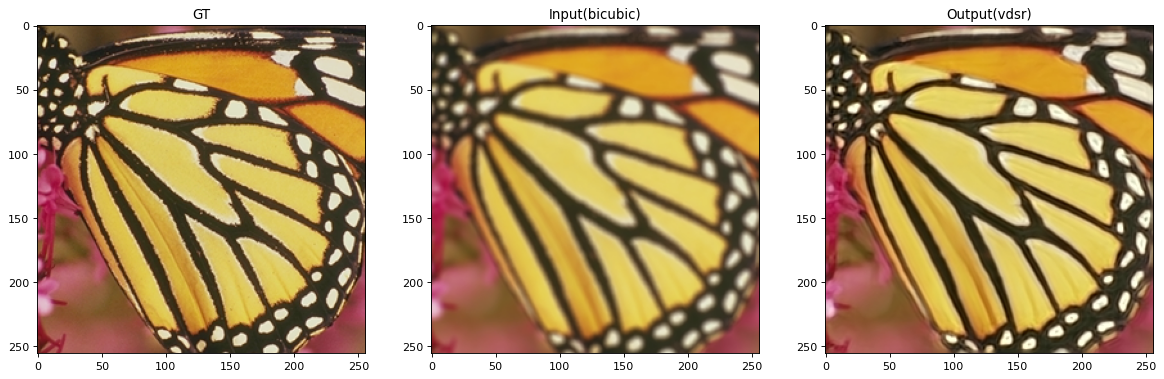

(14.978275355850318, 13.556767365313807)

In [40]:
display_PSNR(im_gt, im_b2, model)

psnr for bicubic is 14.978275355850318dB
psnr for vdsr is 13.53638167291172dB
PSNR improvement is -1.4418936829385984dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 788.4946699207649


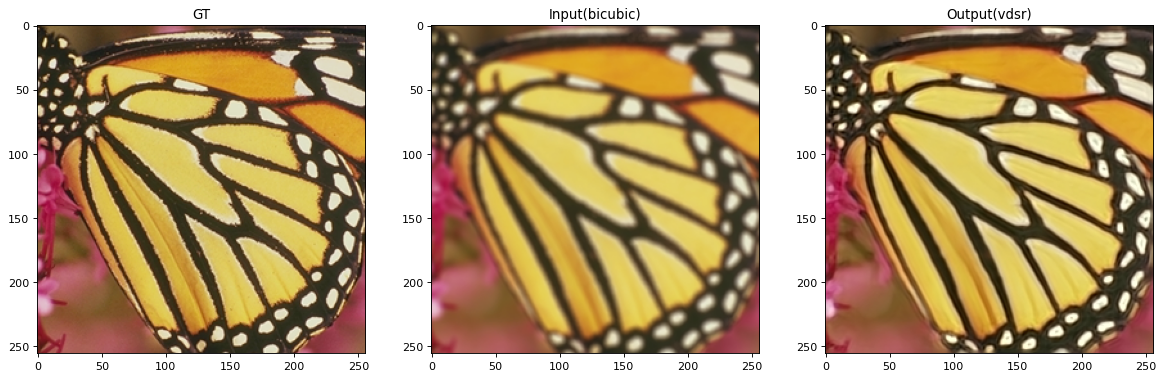

(14.978275355850318, 13.53638167291172)

In [60]:
display_PSNR(im_gt, im_b2, model)

# convert sample videos

In [61]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepmodel3-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  1%|          | 5/900 [00:00<00:20, 42.76it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/muffins30secpercepmodel3-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:26<00:00, 33.51it/s]


True

In [62]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepmodel3-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 11/900 [00:00<00:08, 104.66it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/muffins30secpercepmodel3-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 108.86it/s]


True

In [63]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepmodel3-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:34, 26.19it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/muffins30secpercepmodel3-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:36<00:00, 24.59it/s]


True

In [64]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30secpercepmodel3-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 2/900 [00:00<01:09, 12.95it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/muffins30secpercepmodel3-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:09<00:00, 12.96it/s]


True

In [65]:
dualfile= folder + "muffins30secpercepmodel3-30dual.mp4"

In [66]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [67]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [68]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8percepmodel3.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel3.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:32<00:00, 26.38it/s]


True

In [69]:

dualfile= folder + "super8percepmodel3dual.mp4"

In [70]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [71]:
# compare this model to the last one
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel3.mp4"
dualfile= folder + "super8percepmodel3-tolast-dual.mp4"

In [72]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [52]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longpercepmodel2.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8longpercepmodel2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:15:03<00:00, 26.96it/s]


True

In [53]:
dualfile= folder + "super8longpercepmodel2dual.mp4"

In [54]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [56]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [58]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

  0%|          | 1/7195 [00:00<13:21,  8.98it/s]

Original File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with perception loss/super8percepmodel2x2.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [07:59<00:00, 15.00it/s]


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

frame= 7195 fps=159 q=-1.0 Lsize=   55795kB time=00:02:00.04 bitrate=3807.6kbits/s speed=2.65x    
video:55574kB audio:33kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.337875%
[libx264 @ 0x5613b9c16cc0] frame I:60    Avg QP:19.30  size: 33529
[libx264 @ 0x5613b9c16cc0] frame P:1847  Avg QP:23.16  size: 18966
[libx264 @ 0x5613b9c16cc0] frame B:5288  Avg QP:24.50  size:  3756
[libx264 @ 0x5613b9c16cc0] consecutive B-frames:  1.4%  1.0%  2.5% 95.1%
[libx264 @ 0x5613b9c16cc0] mb I  I16..4: 21.8% 53.6% 24.6%
[libx264 @ 0x5613b9c16cc0] mb P  I16..4:  9.4% 16.8%  4.8%  P16..4: 31.5% 16.3%  5.2%  0.0%  0.0%    skip:15.9%
[libx264 @ 0x5613b9c16cc0] mb B  I16..4:  1.1%  1.1%  0.3%  B16..8: 31.0%  4.7%  0.7%  direct: 1.4%  skip:59.7%  L0:59.2% L1:35.2% BI: 5.6%
[libx264 @ 0x5613b9c16cc0] final ratefactor: 19.04
[libx264 @ 0x5613b9c16cc0] 8x8 transform intra:52.4% inter:73.9%
[libx264 @ 0x5613b9c16cc0] coded y,uvDC,uvAC intra: 46.7% 55.6% 11.4% inter: 12.3% 10.9% 0.1%
[lib